# Generate the model from processed.csv

imports

In [3]:
from sklearn import clone
from sklearn.base import RegressorMixin, TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import json


Read CSV

In [13]:

df = pd.read_csv('data/processed.csv')

# makes models perform worse
# df['difficulty_transform'], lambda_value = stats.boxcox(df['difficulty'])

print(df.head())


   difficulty  average_tempo  average_bpm  note_count  tick_count  \
0         3.5  413197.921548   145.208862        3656      155036   
1         4.5  600000.000000   100.000000        3926       28352   
2         4.5  600000.000000   100.000000        3926       28352   
3         4.5  350818.280820   171.028716        2674      151680   
4         4.5  441740.064844   135.826484        3570       22816   

   note_density  tempo_deviation  unique_note_count  total_duration  \
0      0.023582     97297.985266                 65          155036   
1      0.138473         0.000000                 57           28352   
2      0.138473         0.000000                 57           28352   
3      0.017629     11112.029407                 73          452520   
4      0.156469      7352.818211                 63           43392   

   overlapping_notes  ...  odd_time_signature_count  consecutive_note_std  \
0                283  ...                         1             43.313047   
1   

## Selecting best features

In [14]:
X = df.drop(columns=['difficulty'])
y = df['difficulty']

features_names = X.columns

# Keep the best features
selector = SelectPercentile(r_regression, percentile=40)
X = selector.fit_transform(X, y)
features_kept = features_names[selector.get_support()]
print("Features kept:", features_kept)

Features kept: Index(['note_count', 'unique_note_count', 'overlapping_notes', 'pitch_range',
       'tempo_change_count', 'max_polyphony', 'note_to_note_transition',
       'note_to_chord_transition', 'chord_to_note_transition',
       'chord_to_chord_transition'],
      dtype='object')


## Scaling data and splitting
features have a large difference in scale, scaling makes model perform slightly better

In [15]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Removes randomness from the model across runs
rng = np.random.RandomState(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)


## Tuning hyperparameters

In [ ]:
model_params = {
  'XGB': {
    'model': XGBRegressor(random_state=rng),
    'params': {
        'n_estimators': [100, 200, 500, 1000],
        'gamma': [0.005, 0.01, 0.1, 0],
        'max_depth': [1, 2, 3, 6, 9],
        'learning_rate': [0.001, 0.01, 0.1, 0.015, 1],
        'min_child_weight': [1, 2, 3],
    }
  },
  'RandomForest': {
    'model': RandomForestRegressor(random_state=rng),
    'params': {
      'n_estimators': [100, 200, 500],
      'max_features': ['sqrt', 'log2', None],
      'min_samples_split': [2, 5, 10],
      'max_depth': [None, 1, 2, 10, 20, 30],
      'max_leaf_nodes': [None, 2, 5, 10],
    }
  },
  'SVR': {
    'model': SVR(),
    'params': {
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'C': [0.1, 1, 10, 20, 50, 100],
      'gamma': ['scale', 'auto'],
    }
  },
  'LinearRegression': {
    'model': LinearRegression(),
    'params': {
      'fit_intercept': [True, False],
      'copy_X': [True, False],
    }
  },
  'Ridge': {
    'model': Ridge(random_state=rng),
    'params': {
      'alpha': [0.1, 1, 10, 100],
      'fit_intercept': [True, False],
      'copy_X': [True, False],
    }
  },
  'Lasso': {
    'model': Lasso(random_state=rng),
    'params': {
      'alpha': [0.1, 1, 10, 100],
      'fit_intercept': [True, False],
      'copy_X': [True, False],
    },
  },
  'ElasticNet': {
    'model': ElasticNet(random_state=rng),
    'params': {
      'alpha': [0.1, 1, 10, 100],
      'l1_ratio': [0.1, 0.5, 0.9],
      'fit_intercept': [True, False],
      'copy_X': [True, False],
    },
  },
}

results =  {}

for name, config in model_params.items():
  print('tuning hyperparamerts for ', name)
  # Can edit cv to be more or less, less is faster
  grid_search = GridSearchCV(config['model'], config['params'], cv=3, scoring='r2')
  grid_search.fit(X_train, y_train)
  
  results[name] = {
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
  }
  
  print(f"Best parameters for {name}:", grid_search.best_params_)
  print(f"Best cross-validation score for {name}:", grid_search.best_score_)

with open(f'model_params.json', 'w') as f:
    json.dump(results, f)

tuning hyperparamerts for  LinearRegression
Best parameters for LinearRegression: {'copy_X': True, 'fit_intercept': True}
Best cross-validation score for LinearRegression: 0.6883422140029883
tuning hyperparamerts for  Ridge
Best parameters for Ridge: {'alpha': 1, 'copy_X': True, 'fit_intercept': True}
Best cross-validation score for Ridge: 0.7299000359080617
tuning hyperparamerts for  Lasso
Best parameters for Lasso: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': False}
Best cross-validation score for Lasso: 0.6834461091340264
tuning hyperparamerts for  ElasticNet
Best parameters for ElasticNet: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': False, 'l1_ratio': 0.9}
Best cross-validation score for ElasticNet: 0.6854046940222697


In [10]:
with open ('model_params.json', 'r') as f:
    params = json.load(f)
    
models = {
    'XGB': XGBRegressor(**params['XGB']['best_params']),
    'RandomForest': RandomForestRegressor(**params['RandomForest']['best_params']),
    'LinearRegression':  LinearRegression(**params['LinearRegression']['best_params']),
    'Ridge': Ridge(**params['Ridge']['best_params']),
    'Lasso': Lasso(**params['Lasso']['best_params']),
    'ElasticNet': ElasticNet(**params['ElasticNet']['best_params']),
    'SVR': SVR(**params['SVR']['best_params'])
}


Validation Function

In [8]:
n_folds = 5

def rmse_cross_validation(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [16]:
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    print(f"Model: {name}")
    # Round and clip to ensure valid difficulty levels
    y_pred = np.round(model.predict(X_test) * 2) / 2
    print("Mean squared error:", mean_squared_error(y_test, y_pred))
    print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
    print("R^2 score:", r2_score(y_test, y_pred))
    print("Root mean squared error:", rmse_cross_validation(model).mean())
    print("======================")
    # Save model to disk
    with open(f'./models/{name}_saved_model.pkl', 'wb') as file:
      pickle.dump(model, file)

Model: XGB
Mean squared error: 0.23113207547169812
Mean absolute error: 0.29245283018867924
R^2 score: 0.8392348644298626
Root mean squared error: 0.5717261311692846
Model: RandomForest
Mean squared error: 0.23113207547169812
Mean absolute error: 0.3113207547169811
R^2 score: 0.8392348644298626
Root mean squared error: 0.5416003401046038
Model: LinearRegression
Mean squared error: 0.36792452830188677
Mean absolute error: 0.41509433962264153
R^2 score: 0.744088151541414
Root mean squared error: 0.6391335463067334
Model: Ridge
Mean squared error: 0.37735849056603776
Mean absolute error: 0.4339622641509434
R^2 score: 0.737526309273245
Root mean squared error: 0.6205599738600134
Model: Lasso
Mean squared error: 0.3584905660377358
Mean absolute error: 0.39622641509433965
R^2 score: 0.7506499938095827
Root mean squared error: 0.6672318140548217
Model: ElasticNet
Mean squared error: 0.3443396226415094
Mean absolute error: 0.3867924528301887
R^2 score: 0.7604927572118361
Root mean squared erro

## Create Buckets for each model

Do this to check where the model is performing well and where it is not. Here, we visualize it. Low is 0 - 1.5, mid is 1.5 - 3.5, high is 3.5 - 5.

MAE scores per bucket for XGB bucket
low (1-2)         0.296152
medium (2-3.5)    0.347474
high (3.5-5)      0.481014
dtype: float64
MSE scores per bucket for XGB bucket
low (1-2)         0.156430
medium (2-3.5)    0.186453
high (3.5-5)      0.558800
dtype: float64


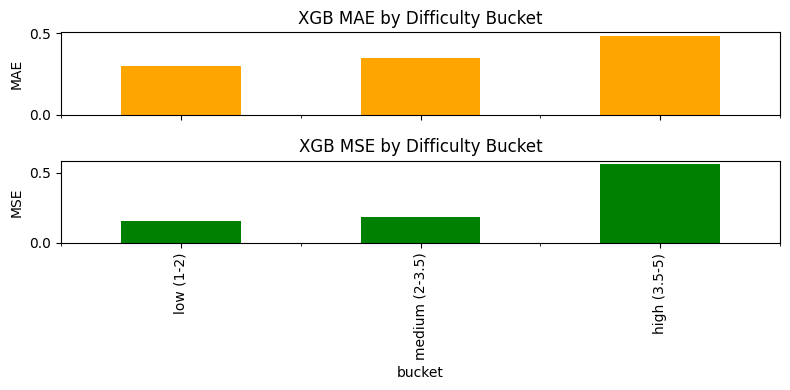

MAE scores per bucket for RandomForest bucket
low (1-2)         0.241030
medium (2-3.5)    0.334683
high (3.5-5)      0.530256
dtype: float64
MSE scores per bucket for RandomForest bucket
low (1-2)         0.101067
medium (2-3.5)    0.176764
high (3.5-5)      0.590060
dtype: float64


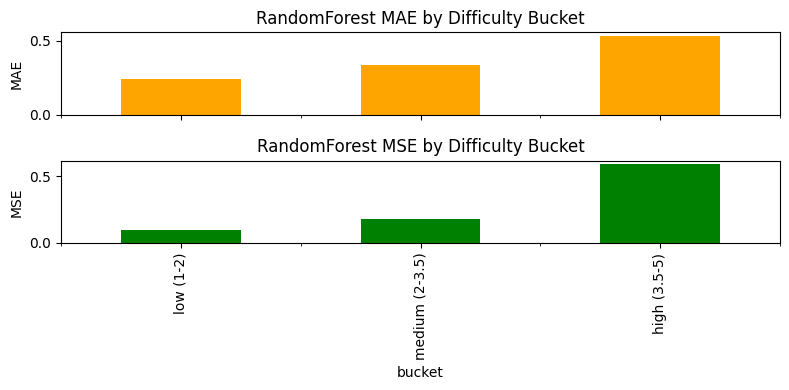

MAE scores per bucket for LinearRegression bucket
low (1-2)         0.358009
medium (2-3.5)    0.429057
high (3.5-5)      0.501799
dtype: float64
MSE scores per bucket for LinearRegression bucket
low (1-2)         0.181790
medium (2-3.5)    0.289848
high (3.5-5)      0.677784
dtype: float64


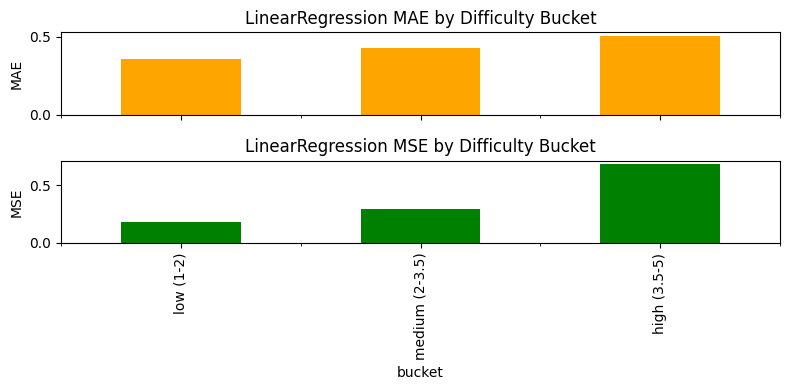

MAE scores per bucket for Ridge bucket
low (1-2)         0.386719
medium (2-3.5)    0.400782
high (3.5-5)      0.474681
dtype: float64
MSE scores per bucket for Ridge bucket
low (1-2)         0.211704
medium (2-3.5)    0.240177
high (3.5-5)      0.610489
dtype: float64


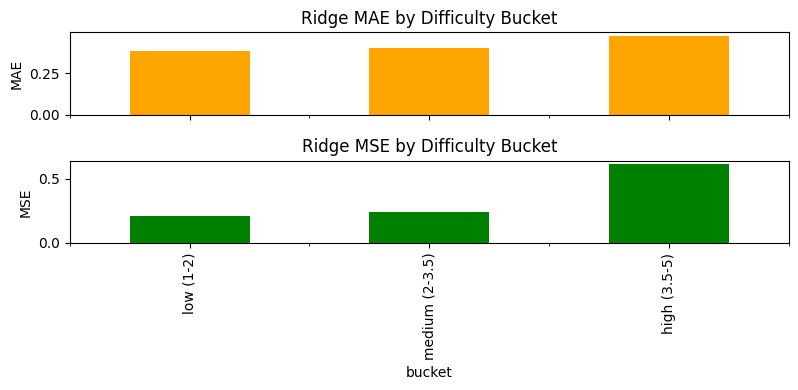

MAE scores per bucket for Lasso bucket
low (1-2)         0.292459
medium (2-3.5)    0.410579
high (3.5-5)      0.576488
dtype: float64
MSE scores per bucket for Lasso bucket
low (1-2)         0.149873
medium (2-3.5)    0.271116
high (3.5-5)      0.760724
dtype: float64


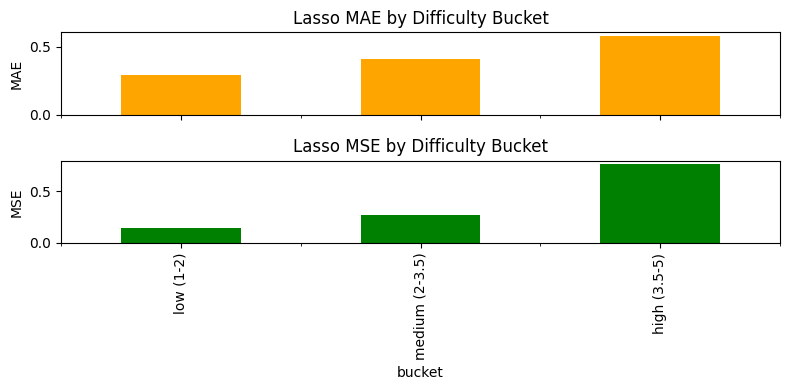

MAE scores per bucket for ElasticNet bucket
low (1-2)         0.280866
medium (2-3.5)    0.410102
high (3.5-5)      0.618474
dtype: float64
MSE scores per bucket for ElasticNet bucket
low (1-2)         0.141474
medium (2-3.5)    0.271808
high (3.5-5)      0.808895
dtype: float64


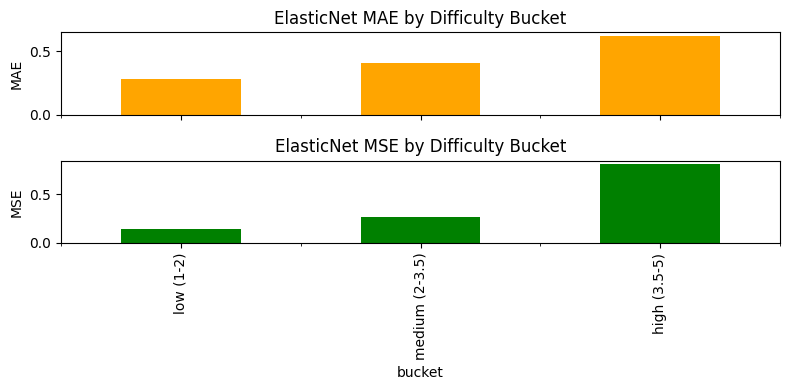

MAE scores per bucket for SVR bucket
low (1-2)         0.191037
medium (2-3.5)    0.485708
high (3.5-5)      0.720553
dtype: float64
MSE scores per bucket for SVR bucket
low (1-2)         0.073879
medium (2-3.5)    0.307309
high (3.5-5)      1.153983
dtype: float64


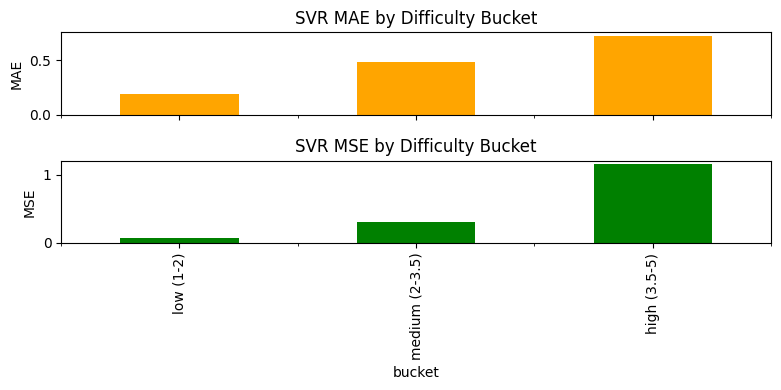

In [17]:
for name, prediction in predictions.items():
    # Comparing true values vs predicted
    df = pd.DataFrame({
      'true': y_test,
      'pred': prediction,
    })
      
    df['bucket'] = pd.cut(df['true'], 
               bins=[0, 2, 3.5, 5],
               labels=['low (1-2)', 'medium (2-3.5)', 'high (3.5-5)'],
               include_lowest=True)
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

    mae_scores = df.groupby('bucket', observed=True)[['true', 'pred']].apply(lambda g: mean_absolute_error(g['true'], g['pred']))
    
    print(f'MAE scores per bucket for {name}', mae_scores)
    mae_scores.plot(kind='bar', ax=axes[0], title=f"{name} MAE by Difficulty Bucket", ylabel="MAE", color='orange', legend=False)

    mse_scores = df.groupby('bucket', observed=True)[['true', 'pred']].apply(lambda g: mean_squared_error(g['true'], g['pred']))
    
    print(f'MSE scores per bucket for {name}', mse_scores)
    mse_scores.plot(kind='bar', ax=axes[1], title=f"{name} MSE by Difficulty Bucket", ylabel="MSE", color='green', legend=False)

    plt.tight_layout()
    plt.show()

## AveragingModel using the models trained earlier

In [19]:
# referenced from https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, scaler, weights_by_bucket=None):
        self.models = models
        self.scaler = scaler
        self.weights_by_bucket = weights_by_bucket

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

From the earlier plots, we can see that the model is performing well in the low and mid buckets, but not so well in the high bucket. To try and lessen this effect we average the performance of the best performing models: Xgboost and RandomForest.

In [21]:
models_to_use = [models['XGB'], models['RandomForest']]
averaged_models = AveragingModels(models=models_to_use, scaler = scaler)
score = rmse_cross_validation(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(X_train, y_train)
y_pred = np.round(averaged_models.predict(X_test) * 2) / 2

print("Mean squared error:", mean_squared_error(y_test, y_pred))
print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("R^2 score:", r2_score(y_test, y_pred))

with open(f'./models/averaged_models.pkl', 'wb') as file:
    pickle.dump(averaged_models, file)



 Averaged base models score: 0.5445 (0.0887)

Mean squared error: 0.21226415094339623
Mean absolute error: 0.27358490566037735
R^2 score: 0.8523585489662003


# Predicting the difficulty for the rest of the songs

In [22]:
with open('./models/averaged_models.pkl', 'rb') as file:
    averaged_models = pickle.load(file)

df = pd.read_csv('data/all_song_features.csv')

# Select only the columns used during training
X_unseen = df.loc[:, features_kept]

# Scale the data using the same scaler from training
X_unseen = scaler.transform(X_unseen)

y_pred = np.round(averaged_models.predict(X_unseen) * 2) / 2

predictions = pd.DataFrame({
    'file': df['file'],
    'predicted_difficulty': y_pred
}).to_csv('predictions.csv', index=False)



c:\Users\tanbi\OneDrive\Desktop\projects\music-ai\test\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
